# Obesity Level Dataset Analysis

by Neil Chen, University of Colorado Boulder.

## Project Topic

This project aims to train a model to predict a person's obesity level, based on his/her eating habits and physical conditions. It is a **multi-class classification problem**, since the prediction result will be a obesity level with multiple class labels, from "Normal_Weight" all the way up to "Obesity_Type_III".

The motivation of doing this research is that, I know BMI (Body Mass Index) is a popular criteria to determine obesity levels, but it is not very accurate since it ignores many different other factors, such as gender, fat distribution, eating habit, etc. I am interested to understand more of the contributing factors of obesity level, which can hopefully help us develop healthy lifestyles to reduce obesity in the future.

We will first use use the basic models like **Logistic Regression**, **Decision Tree** as the baseline for comparison, then we will try the ensemble method **Ada Boosting**, as well as **Support Vector Machines (SVM)** to fit the data.

Lastly, we will summarize the performance of each model and how they compare with each other, and discuss which models can be good choices for this data set.

## Data

The dataset used in this project is from the following source:

*Dataset for estimation of obesity levels based on eating habits and physical condition in individuals from Colombia, Peru and Mexico
By Fabio Mendoza Palechor, Alexis De la Hoz Manotas. 2019*

*Published in Data in Brief*

<https://archive.ics.uci.edu/dataset/544/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition>

It is tabulated data, with 17 features and 2111 samples, as we will see below.

## Data Cleaning


In [67]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import label_binarize
import statsmodels.api as sm
from sklearn.metrics import precision_score, recall_score

In [94]:
# https://archive.ics.uci.edu/dataset/544/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition
df = pd.read_csv("ObesityDataSet_raw_and_data_sinthetic.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF                             21

In [95]:
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


We can see that the data has a few real-valued features, such as (age, height, weight);
and most other features are categorical values.

So in order to train models with the data, we need to do some transformation on the categorical data first, by mapping them into integer values.

In [96]:
# Check the existing unique values for each categorical valued features

df['CAEC'].unique()
# array(['Sometimes', 'Frequently', 'Always', 'no'], dtype=object)
df['CALC'].unique()
# array(['no', 'Sometimes', 'Frequently', 'Always'], dtype=object)
df['MTRANS'].unique()
# array(['Public_Transportation', 'Walking', 'Automobile', 'Motorbike',  'Bike'], dtype=object)
df['NObeyesdad'].unique()
# array(['Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II',
       # 'Obesity_Type_I', 'Insufficient_Weight', 'Obesity_Type_II',
       # 'Obesity_Type_III'], dtype=object)
df['Gender'].unique()
# array(['Female', 'Male'], dtype=object)
df['CAEC'].unique()
# array(['no', 'yes'], dtype=object)
df['FAVC'].unique()
# array(['no', 'yes'], dtype=object)
df['family_history_with_overweight'].unique()
# array(['yes', 'no'], dtype=object)

array(['yes', 'no'], dtype=object)

In [97]:
# Perform data type munging for categorical valued data
yn_mapping = {'no': 0, 'yes': 1}
df['family_history_with_overweight'] = df['family_history_with_overweight'].map(yn_mapping)
df['FAVC'] = df['FAVC'].map(yn_mapping)
df['SMOKE'] = df['SMOKE'].map(yn_mapping)
df['SCC'] = df['SCC'].map(yn_mapping)

freq_mapping = {'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3}
df['CAEC'] = df['CAEC'].map(freq_mapping)
df['CALC'] = df['CALC'].map(freq_mapping)

gender_mapping = {'Female': 1, 'Male': 2}
df['Gender'] = df['Gender'].map(gender_mapping)

trans_mapping = {'Public_Transportation': 1, 'Walking': 2, 'Automobile': 3, 'Motorbike': 4,  'Bike': 5}
df['MTRANS'] = df['MTRANS'].map(trans_mapping)

weight_level_mapping = {
    "Insufficient_Weight": 1,
    "Normal_Weight": 2,
    "Overweight_Level_I": 3,
    "Overweight_Level_II": 4,
    "Obesity_Type_I": 5,
    "Obesity_Type_II": 6,
    "Obesity_Type_III": 7
}
df['NObeyesdad'] = df['NObeyesdad'].map(weight_level_mapping)

# Rename a few columns for clarity
df = df.rename(columns={
    'family_history_with_overweight': 'family_history',
    'FAVC': 'caloric_food',
    'FCVC': 'vegetable',
    'NCP': 'main_meals_per_day',
    'CAEC': 'eat_between',
    'SCC': 'monitor_calory',
    'FAF': 'physical_activity_freq',
    'TUE': 'tech_device_usage',
    'CALC': 'alcohol_freq'
})



## Exploratory Data Analysis (EDA)

In [98]:
# If we check the data again, we can see now all of the features are numbers instead of strings.
# which is good for model training.
df.head()


,Gender,Age,Height,Weight,family_history,caloric_food,vegetable,main_meals_per_day,eat_between,SMOKE,CH2O,monitor_calory,physical_activity_freq,tech_device_usage,alcohol_freq,MTRANS,NObeyesdad
0,1,21.0,1.62,64.0,1,0,2.0,3.0,1,0,2.0,0,0.0,1.0,0,1,2
1,1,21.0,1.52,56.0,1,0,3.0,3.0,1,1,3.0,1,3.0,0.0,1,1,2
2,2,23.0,1.80,77.0,1,0,2.0,3.0,1,0,2.0,0,2.0,1.0,2,1,2
3,2,27.0,1.80,87.0,0,0,3.0,3.0,1,0,2.0,0,2.0,0.0,2,2,3
4,2,22.0,1.78,89.8,0,0,2.0,1.0,1,0,2.0,0,0.0,0.0,1,1,4


In [99]:
df['NObeyesdad'].unique()

array([2, 3, 4, 5, 1, 6, 7], dtype=int64)

In [8]:
# Check the feature correlations
df.corr()

,Gender,Age,Height,Weight,family_history,caloric_food,vegetable,main_meals_per_day,eat_between,SMOKE,CH2O,monitor_calory,physical_activity_freq,tech_device_usage,alcohol_freq,MTRANS,NObeyesdad
Gender,1.000000,0.048394,0.618466,0.161668,0.102512,0.064934,-0.274505,0.067600,-0.091543,0.044698,0.107930,-0.102633,0.189607,0.017269,-0.007616,0.164116,-0.031464
Age,0.048394,1.000000,-0.025958,0.202560,0.205725,0.063902,0.016291,-0.043944,-0.083739,0.091987,-0.045304,-0.116283,-0.144938,-0.296931,0.044487,0.567983,0.282913
Height,0.618466,-0.025958,1.000000,0.463136,0.247684,0.178364,-0.038121,0.243672,-0.048818,0.055499,0.213376,-0.133753,0.294709,0.051912,0.129732,0.085768,0.133565
Weight,0.161668,0.202560,0.463136,1.000000,0.496820,0.272300,0.216125,0.107469,-0.287493,0.025746,0.200575,-0.201906,-0.051436,-0.071561,0.206677,-0.046615,0.913251
family_history,0.102512,0.205725,0.247684,0.496820,1.000000,0.208036,0.040372,0.071370,-0.169787,0.017385,0.147437,-0.185422,-0.056673,0.022943,-0.036676,0.065036,0.505148
caloric_food,0.064934,0.063902,0.178364,0.272300,0.208036,1.000000,-0.027283,-0.007000,-0.150068,-0.050660,0.009719,-0.190658,-0.107995,0.068417,0.089520,-0.009102,0.247793
vegetable,-0.274505,0.016291,-0.038121,0.216125,0.040372,-0.027283,1.000000,0.042216,0.054670,0.014320,0.068461,0.071852,0.019939,-0.101135,0.060781,-0.065098,0.227759
main_meals_per_day,0.067600,-0.043944,0.243672,0.107469,0.071370,-0.007000,0.042216,1.000000,0.097801,0.007811,0.057088,-0.015624,0.129504,0.036326,0.071747,0.059022,0.026690
eat_between,-0.091543,-0.083739,-0.048818,-0.287493,-0.169787,-0.150068,0.054670,0.097801,1.000000,0.055282,-0.144995,0.109179,0.030110,0.048567,-0.047540,-0.003556,-0.329350
SMOKE,0.044698,0.091987,0.055499,0.025746,0.017385,-0.050660,0.014320,0.007811,0.055282,1.000000,-0.031995,0.047731,0.011216,0.017613,0.082471,0.021045,0.003442


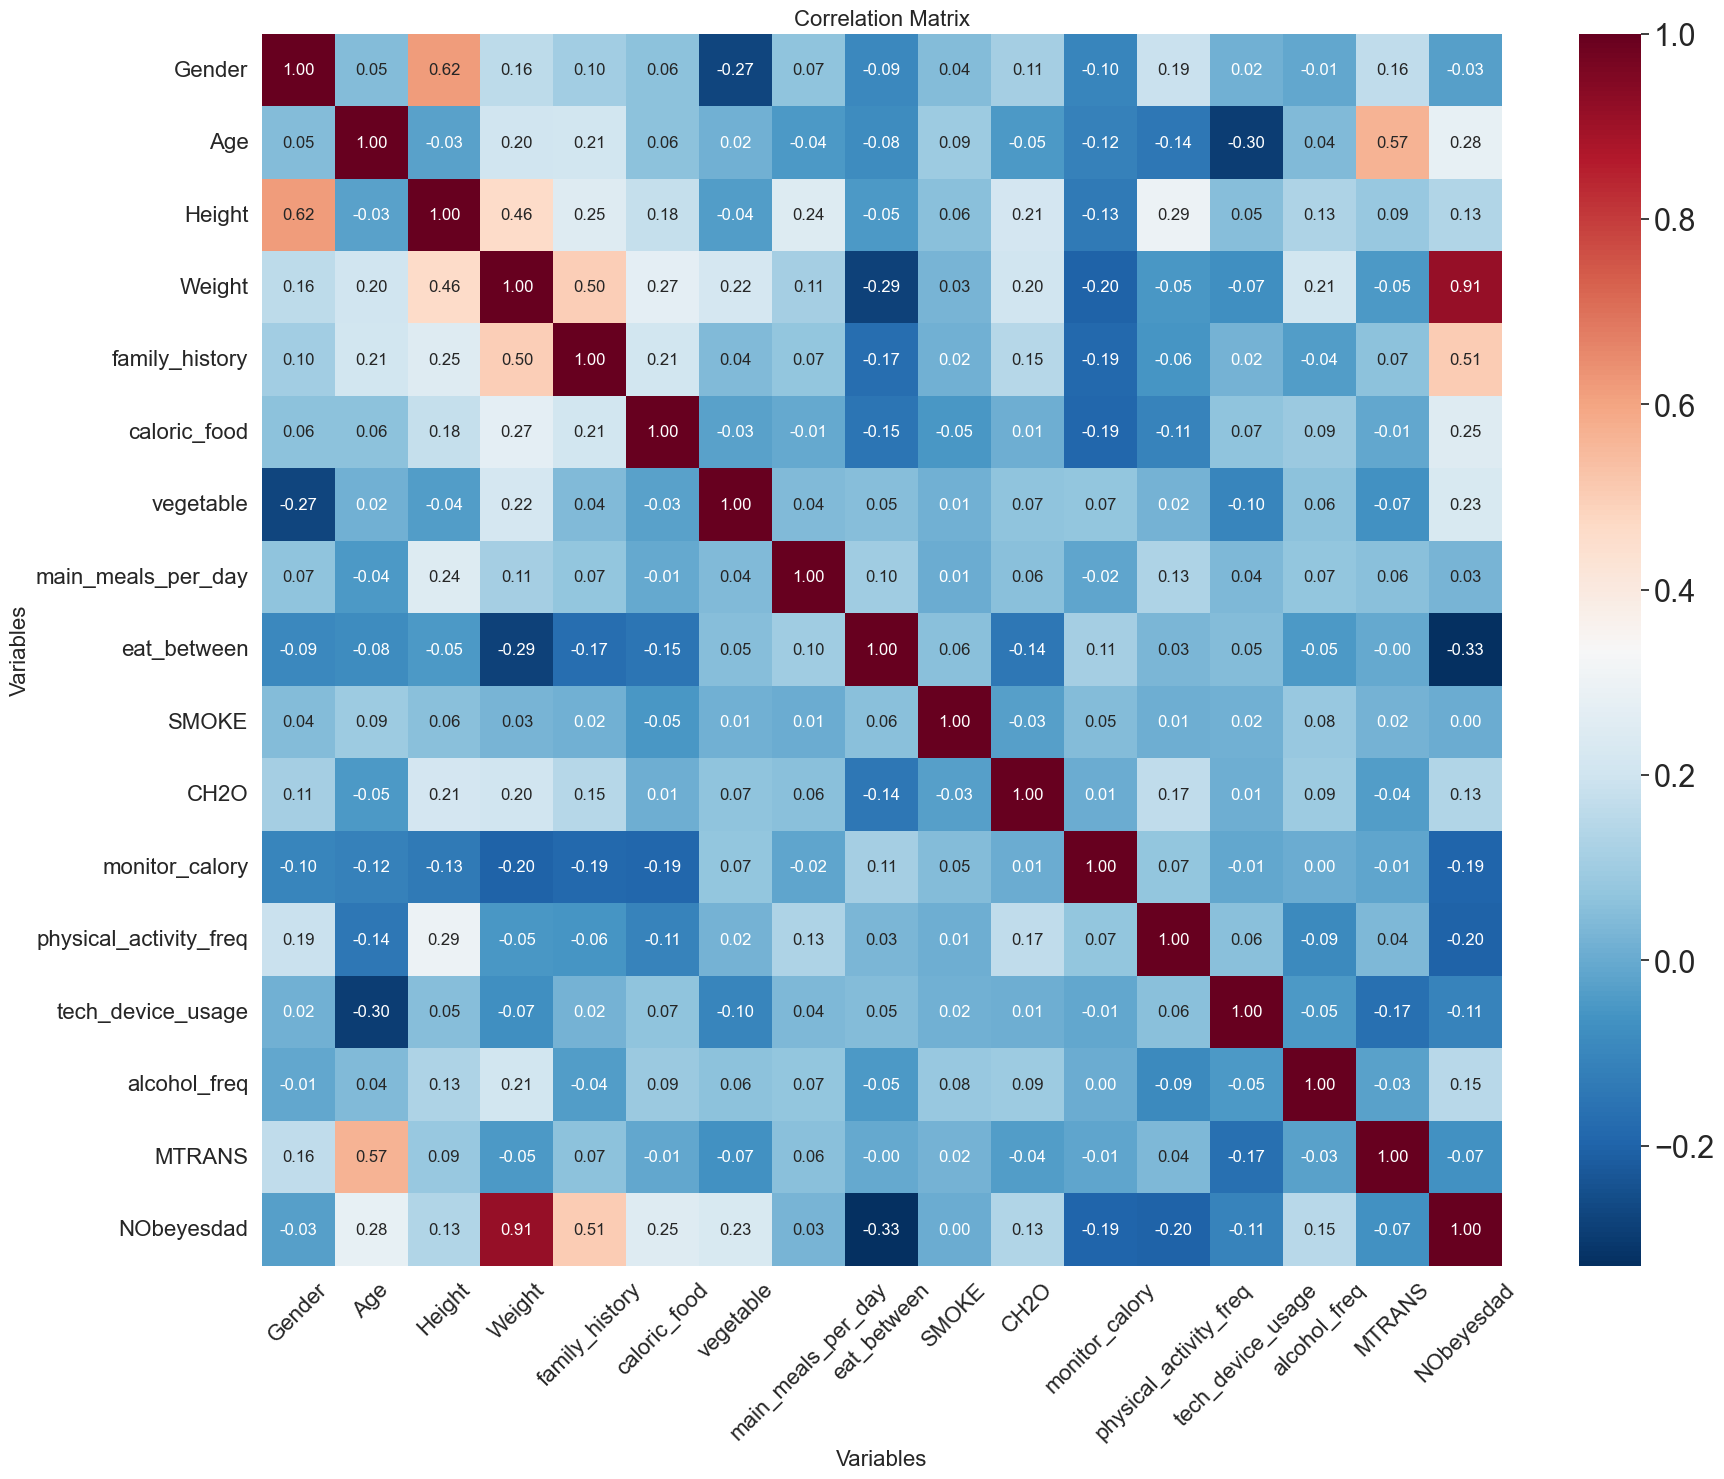

In [78]:
# Visualize the correlations with a heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="RdBu_r", annot_kws={"size": 12})

plt.xlabel("Variables", fontsize=16)
plt.ylabel("Variables", fontsize=16)

plt.title("Correlation Matrix", fontsize=16)

plt.xticks(fontsize=16, rotation=45)
plt.yticks(fontsize=16)
plt.show()

We can see some interesting slight correlations between some features. For example, 

- `Height` and `Gender`: 0.62
- `Age` and `MTRANS`: 0.57

The slight correlations shown above are reasonable. In average man is higher than female, and children or older people may have limited options of transportation which are feasible to them.

As the correlation score is quite low, we can assume for now that no features need to be excluded from the training. 

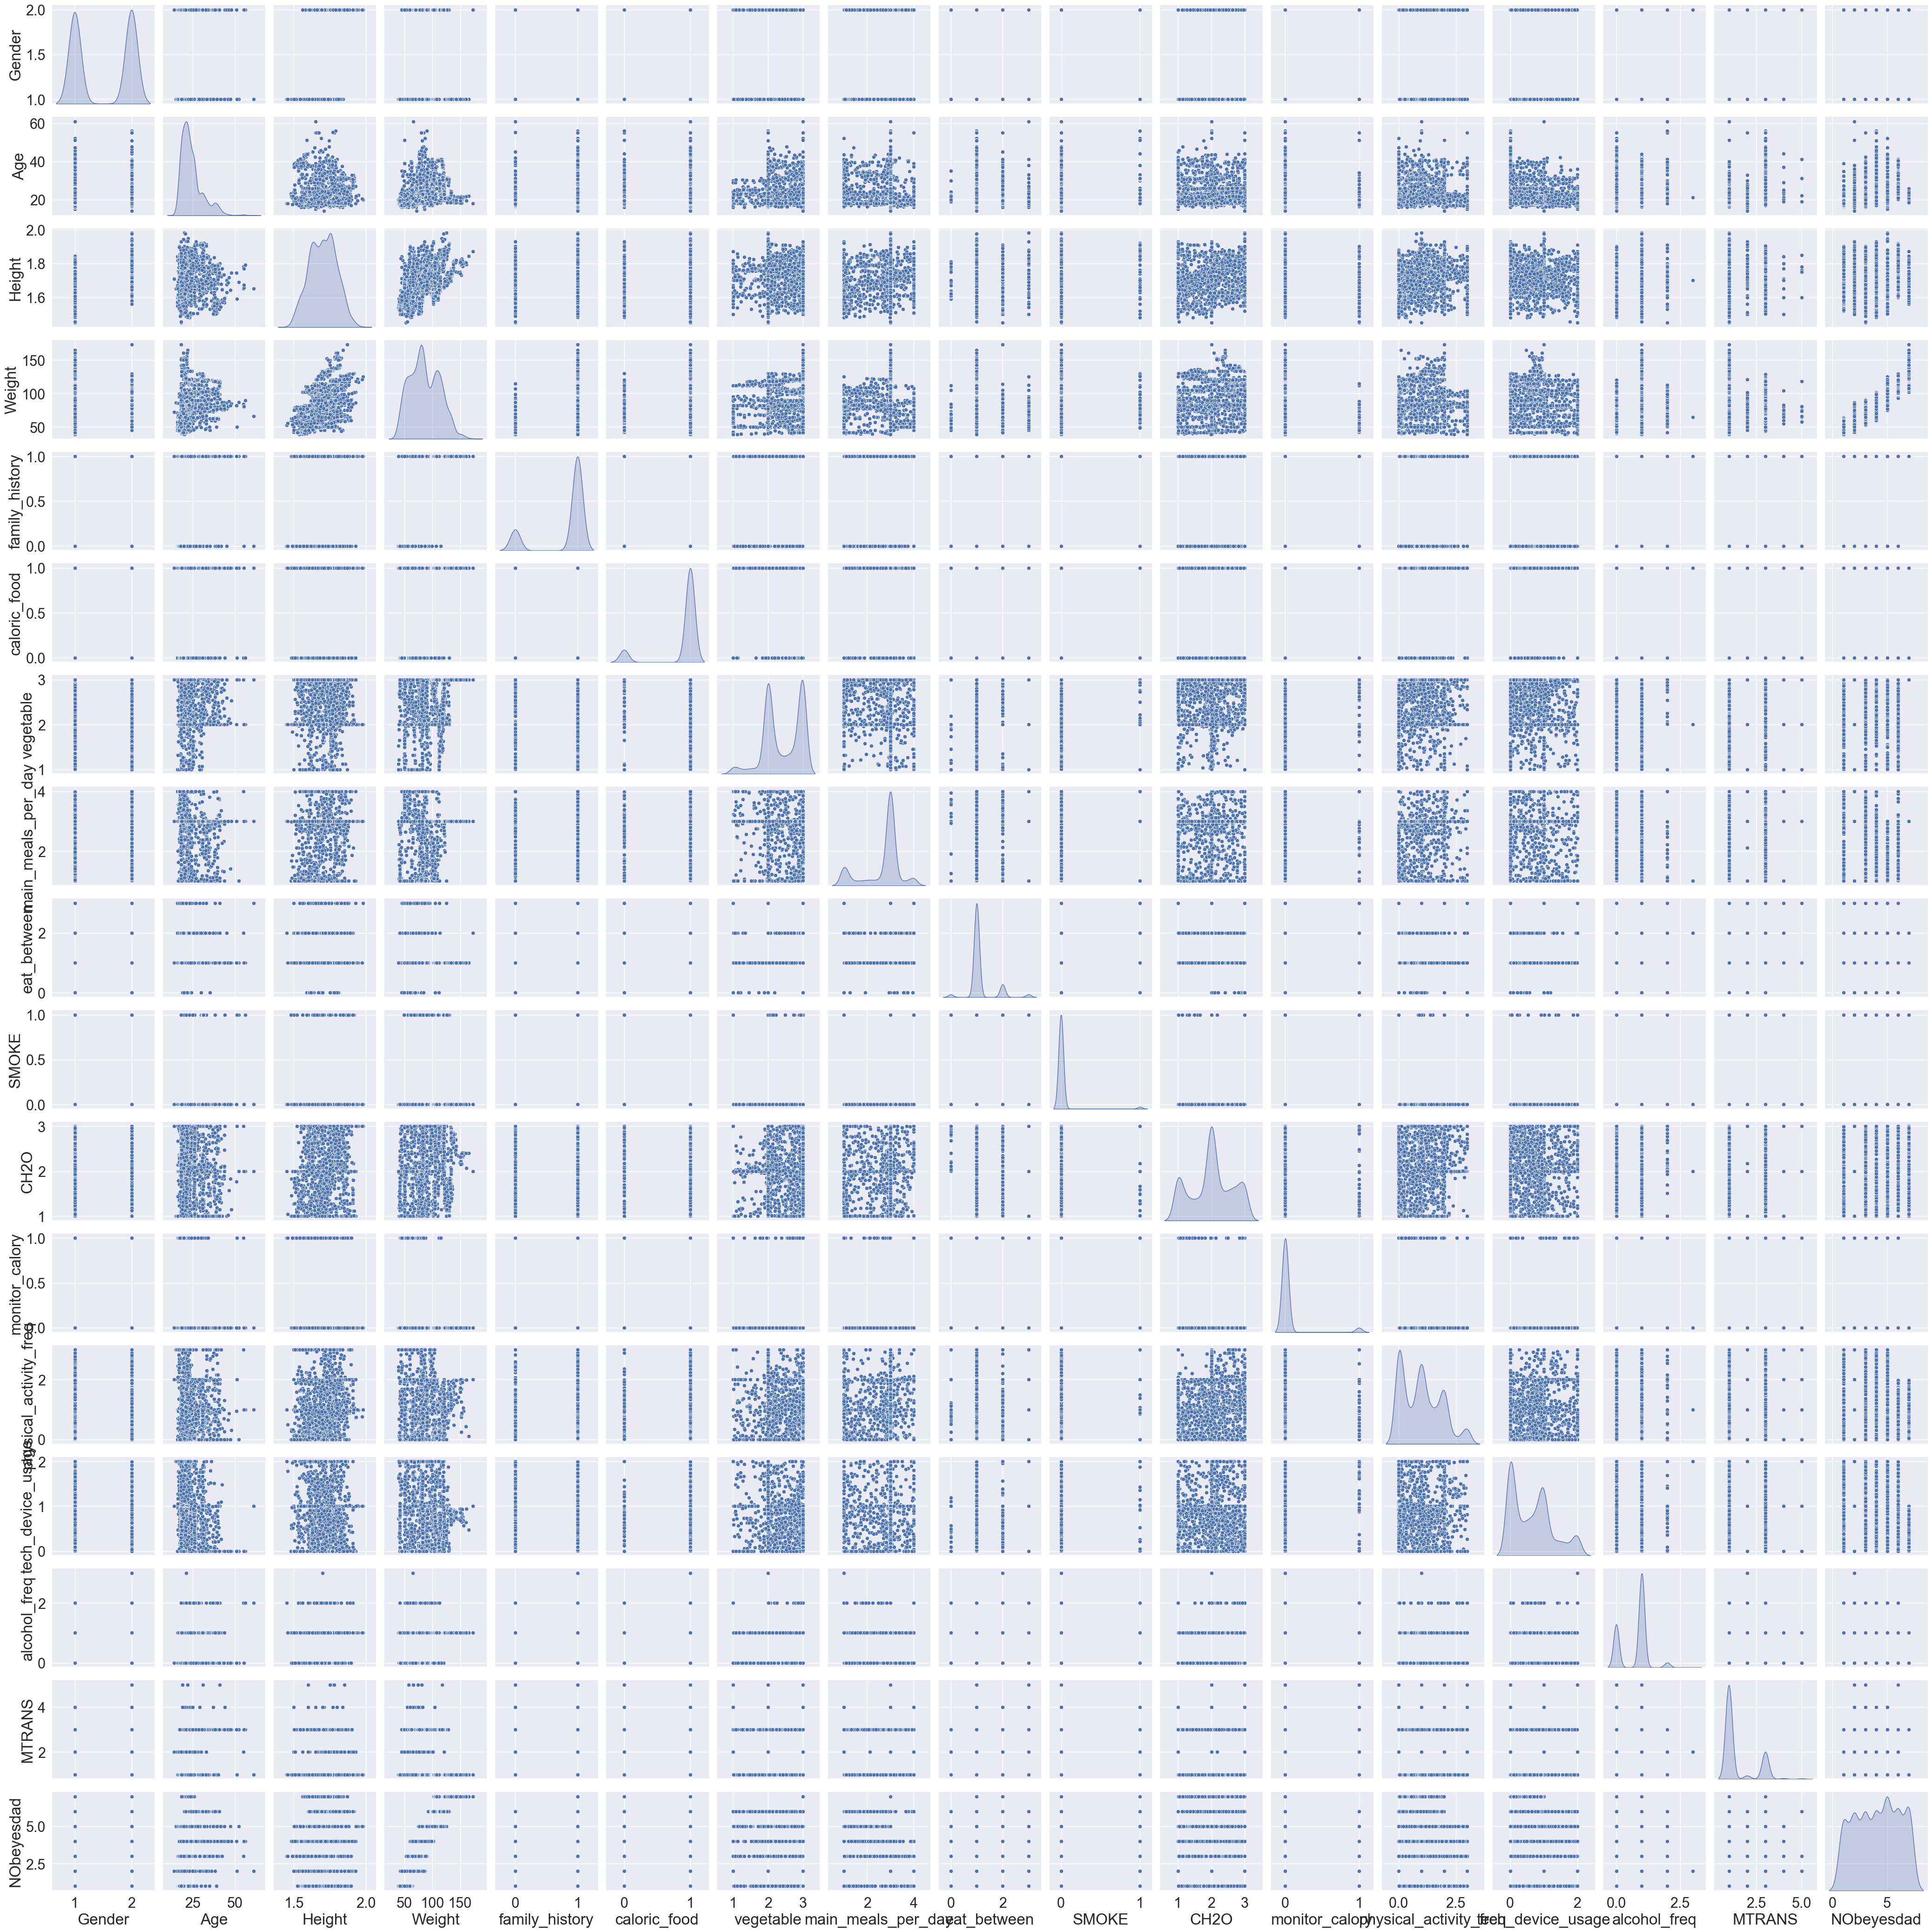

In [79]:
# Also we can check the pair plot
sns.set(font_scale=2)
sns.pairplot(df, diag_kind='kde')
plt.xticks(fontsize=16, rotation=45)
plt.yticks(fontsize=16)
plt.show()

In this plot diagram we can also see that there are no strong correlation between each other. The data is mostly evenly distributed.
And the dots lined up show the characteristic of categorical data, but they are also almost evenly distributed.

With pair of features slightly correlated to each other, we can see that the pair plot between them may look slightly different.

## Models

### 1. Logistic Regression

In [66]:
from sklearn.linear_model import LogisticRegression

X = df.iloc[:, :-1]
y = df.iloc[:, -1]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=5)

start_time = time.time()
LogReg = LogisticRegression(solver='liblinear').fit(x_train, y_train)
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Model fitting took {elapsed_time:.4f} seconds")

Model fitting took 0.0390 seconds


In [12]:
LogReg.coef_

array([[ 1.37802198, -0.01551417,  5.60058719, -0.38616373,  0.25341628,
         0.63938777,  1.40601274,  0.7989738 ,  0.21495725, -1.16213836,
         0.33364504, -0.62879065,  0.20294431,  0.67354217, -0.13533699,
         0.19767055],
       [ 1.00796194, -0.03040577,  0.7325927 , -0.0585472 , -0.26361312,
        -0.61641277, -0.29935298, -0.05190606,  0.6637971 ,  1.02440215,
        -0.33328834,  0.47821877,  0.18658266, -0.2339602 ,  0.14472156,
         0.21051898],
       [-0.14609738, -0.02879279,  1.23503196, -0.03991899,  0.61467281,
         1.16808077, -0.50059797, -0.22804304, -1.22872819, -1.28225841,
         0.30330877,  1.37966873,  0.04528982, -0.37340386,  1.03264356,
         0.17909773],
       [ 0.99004582,  0.11509898,  0.1051714 , -0.0289065 ,  1.68641594,
        -1.62799748, -0.3751189 , -0.37858841, -0.52621697, -0.72541113,
        -0.0172086 , -1.1080871 , -0.09829866,  0.42568453, -0.06421259,
        -0.23064147],
       [-0.16280305,  0.00904694, -2

### Logistic Regression - Results and Analysis

Macro AUC: 0.93
Micro AUC: 0.95


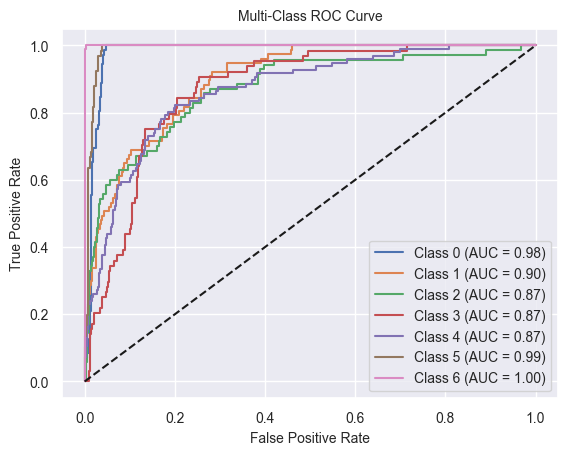

In [13]:
y_scores = LogReg.predict_proba(x_test)
n_classes = 7

y_true_bin = label_binarize(y_test, classes=[1, 2, 3, 4, 5, 6, 7])

# Calculate AUC
auc_macro = roc_auc_score(y_true_bin, y_scores, average='macro')
auc_micro = roc_auc_score(y_true_bin, y_scores, average='micro')

print(f"Macro AUC: {auc_macro:.2f}")
print(f"Micro AUC: {auc_micro:.2f}")

# Draw ROC curve
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc_score(y_true_bin[:, i], y_scores[:, i]):.2f})")

plt.tick_params(axis='both', labelsize=10)
plt.plot([0, 1], [0, 1], 'k--')  # baseline
plt.xlabel("False Positive Rate", fontsize=10)
plt.ylabel("True Positive Rate", fontsize=10)
plt.title("Multi-Class ROC Curve", fontsize=10)
plt.legend(loc="lower right", fontsize=10)
plt.show()

In [14]:
# Analyze the accuracy and recall of the model

y_pred = LogReg.predict(x_test)
# calculate Precision and Recall for each class
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)

# calculate Macro average
macro_precision = precision_score(y_test, y_pred, average='macro')
macro_recall = recall_score(y_test, y_pred, average='macro')

# calculate Weighted average
weighted_precision = precision_score(y_test, y_pred, average='weighted')
weighted_recall = recall_score(y_test, y_pred, average='weighted')

# print results
print(f"Precision per class: {precision}")
print(f"Recall per class: {recall}")
print(f"Macro average Precision: {macro_precision}")
print(f"Macro average Recall: {macro_recall}")
print(f"Weighted average Precision: {weighted_precision}")
print(f"Weighted average Recall: {weighted_recall}")


Precision per class: [0.79012346 0.77272727 0.57142857 0.38709677 0.62352941 0.74157303
 0.92222222]
Recall per class: [0.88888889 0.44155844 0.62857143 0.375      0.55208333 1.
 1.        ]
Macro average Precision: 0.6869572489763299
Macro average Recall: 0.6980145846217275
Weighted average Precision: 0.694148050446688
Weighted average Recall: 0.696969696969697


### 2. Decision Tree

Training, and result analysis

In [81]:
from sklearn.tree import DecisionTreeClassifier

start_time = time.time()
clf = DecisionTreeClassifier(max_depth=15, max_leaf_nodes=15, random_state=0)
clf.fit(x_train, y_train)
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Model fitting took {elapsed_time:.4f} seconds")

y_pred = clf.predict(x_test)

# calculate the precision and recall score
prec = precision_score(y_test, y_pred, average='weighted', zero_division=1)
print('Precision: ', prec)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
print('Recall: ', recall)

Model fitting took 0.0085 seconds
Precision:  0.826380596182603
Recall:  0.8200757575757576


Index(['Gender', 'Age', 'Height', 'Weight', 'family_history', 'caloric_food',
       'vegetable', 'main_meals_per_day', 'eat_between', 'SMOKE', 'CH2O',
       'monitor_calory', 'physical_activity_freq', 'tech_device_usage',
       'alcohol_freq', 'MTRANS'],
      dtype='object')
                   Feature  Importance
3                   Weight    0.507297
0                   Gender    0.209719
2                   Height    0.209243
1                      Age    0.045216
5             caloric_food    0.028525
4           family_history    0.000000
6                vegetable    0.000000
7       main_meals_per_day    0.000000
8              eat_between    0.000000
9                    SMOKE    0.000000
10                    CH2O    0.000000
11          monitor_calory    0.000000
12  physical_activity_freq    0.000000
13       tech_device_usage    0.000000
14            alcohol_freq    0.000000
15                  MTRANS    0.000000


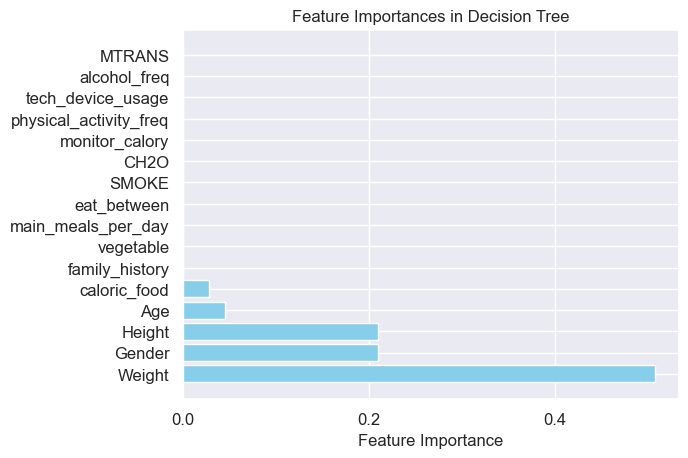

In [93]:
feature_names = X.columns
print(feature_names)
importances = clf.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print sorted feature names by their importance
print(feature_importance_df)

# Visualize the features by importance
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance", fontsize=12)
plt.title("Feature Importances in Decision Tree", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## 3. Ada Boosting

Training, and result analysis.

In [58]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

weak_learner = DecisionTreeClassifier(max_leaf_nodes=8)
n_estimators = 300

start_time = time.time()

# Fit the model
adaboost_clf = AdaBoostClassifier(
    estimator=weak_learner,
    n_estimators=n_estimators,
    random_state=42,
    algorithm='SAMME'
).fit(x_train, y_train)

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Model fitting took {elapsed_time:.4f} seconds")


Model fitting took 1.5363 seconds


In [17]:
# Analysis

from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

dummy_clf = DummyClassifier()

# Helper method to calculate misclassification error
def misclassification_error(y_true, y_pred):
    return 1 - accuracy_score(y_true, y_pred)


weak_learners_misclassification_error = misclassification_error(
    y_test, weak_learner.fit(x_train, y_train).predict(x_test)
)

dummy_classifiers_misclassification_error = misclassification_error(
    y_test, dummy_clf.fit(x_train, y_train).predict(x_test)
)

print(
    "DecisionTreeClassifier's misclassification_error: "
    f"{weak_learners_misclassification_error:.3f}"
)
print(
    "DummyClassifier's misclassification_error: "
    f"{dummy_classifiers_misclassification_error:.3f}"
)

DecisionTreeClassifier's misclassification_error: 0.278
DummyClassifier's misclassification_error: 0.818


C:\Users\chenr.000\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


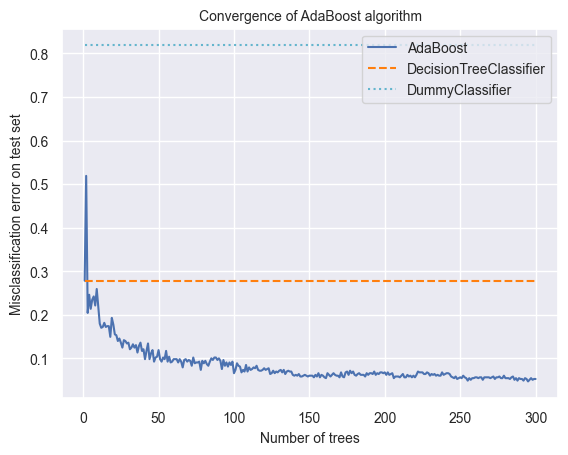

In [18]:
# Show the staged misclassification error on each iteration step
boosting_errors = pd.DataFrame(
    {
        "Number of trees": range(1, n_estimators + 1),
        "AdaBoost": [
            misclassification_error(y_test, y_pred)
            for y_pred in adaboost_clf.staged_predict(x_test)
        ],
    }
).set_index("Number of trees")
ax = boosting_errors.plot()
ax.set_xlabel("Number of trees", fontsize=10)
ax.set_ylabel("Misclassification error on test set", fontsize=10)
ax.set_title("Convergence of AdaBoost algorithm", fontsize=10)

plt.plot(
    [boosting_errors.index.min(), boosting_errors.index.max()],
    [weak_learners_misclassification_error, weak_learners_misclassification_error],
    color="tab:orange",
    linestyle="dashed",
)
plt.plot(
    [boosting_errors.index.min(), boosting_errors.index.max()],
    [
        dummy_classifiers_misclassification_error,
        dummy_classifiers_misclassification_error,
    ],
    color="c",
    linestyle="dotted",
)
plt.legend(["AdaBoost", "DecisionTreeClassifier", "DummyClassifier"], loc=1, fontsize=10)
plt.tick_params(axis='both', labelsize=10)
plt.show()

The plot shows the missclassification error on the test set after each boosting iteration. We see that the error of the boosted trees converges to an error of around 0.05 with about 300 trees, indicating a significantly higher accuracy compared to a single tree, as illustrated by the dashed line in the plot.


### Performance of Ada Boosting

In [26]:
y_pred = adaboost_clf.predict(x_test)

prec = precision_score(y_test, y_pred, average='weighted', zero_division=1)
print('Precision: ', prec)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
print('Recall: ', recall)

Precision:  0.9487213004632262
Recall:  0.946969696969697


## 4. SVM

In [82]:
from sklearn.svm import LinearSVC

# Since it's a multi-class classification problem, we use 'ovr' (one over the rest) as the parameter value
lsvm = LinearSVC(random_state=0, loss='hinge', C=1.0, multi_class='ovr')
lsvm.fit(x_train, y_train)

w = lsvm.coef_[0]
b = lsvm.intercept_
print('w', w)
print('b', b)

lsvm_accuracy = lsvm.score(x_test, y_test, sample_weight=None)
print(lsvm_accuracy)

w [ 0.45522095 -0.01486737  3.18022554 -0.17151964  0.1409069   0.08913361
  0.44017396  0.23836873  0.05890229 -0.60908715  0.08131088 -0.22890199
  0.05611146  0.20701744 -0.08541636  0.12296771]
b [ 0.7734174   0.58353864  0.02007598 -0.43400787 -0.02532499 -1.20059725
 -0.48229214]
0.1875


C:\Users\chenr.000\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


**The training result above shows that, the accuracy of 0.1875 is too low, which means the linear SVC model does not fit with the data. So we need to use non-linear models instead.**

In [32]:
# Non-linear SVM
from sklearn.svm import SVC

# Use the default radial basis function (rbf) kernel
nlsvm = SVC(kernel="rbf", C=1.0, gamma=1)
nlsvm.fit(x_train, y_train)

accuracy = nlsvm.score(x_test, y_test)
print(accuracy)

0.7916666666666666


#### Use grid search to search for optimal hyperparameter values

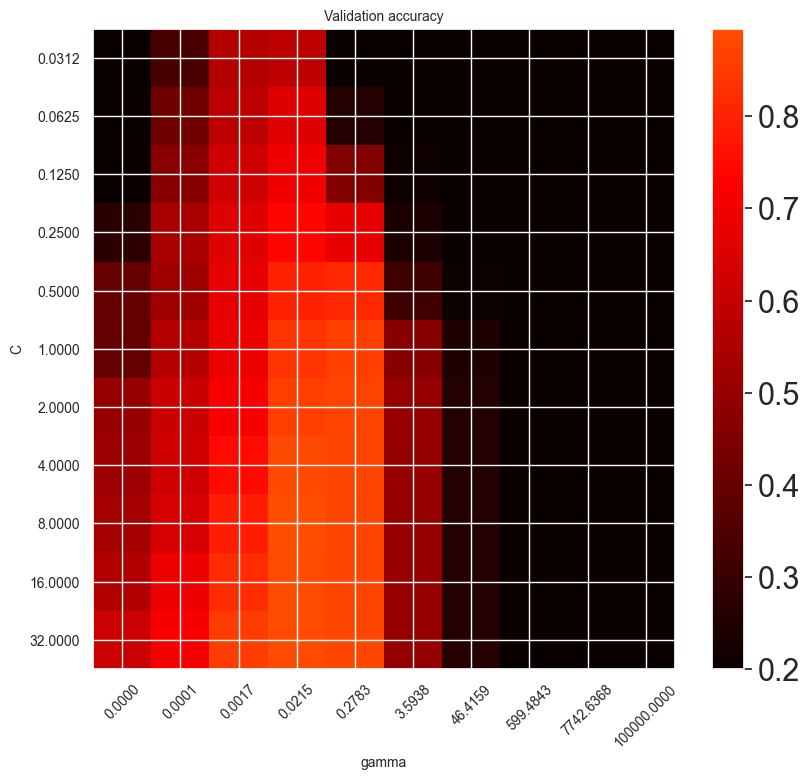

In [44]:
# Use grid search to search for optimal hyperparameter values

from matplotlib.colors import Normalize

class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

# Helper function for plot search grid, copied from week 6 project
def plotSearchGrid(grid):
    
    scores = [x for x in grid.cv_results_["mean_test_score"]]
    scores = np.array(scores).reshape(len(grid.param_grid["C"]), len(grid.param_grid["gamma"]))

    plt.figure(figsize=(10, 8))
    plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
               norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
    plt.xlabel('gamma', fontsize=10)
    plt.ylabel('C', fontsize=10)
    plt.colorbar()

    # Format gamma and C values, with 4 decimal points
    formatted_gamma = [f"{x:.4f}" for x in grid.param_grid["gamma"]]
    formatted_C = [f"{x:.4f}" for x in grid.param_grid["C"]]    
    plt.xticks(np.arange(len(grid.param_grid["gamma"])), formatted_gamma, rotation=45, fontsize=10)
    plt.yticks(np.arange(len(grid.param_grid["C"])), formatted_C, fontsize=10)
    plt.title('Validation accuracy', fontsize=10)
    plt.show()

from sklearn.model_selection import cross_val_score, GridSearchCV

param_grid = {
    'C': [2**i for i in range(-5, 6)],
    'gamma': np.logspace(-5, 5, 10)
}
model = SVC(kernel='rbf')
grid = GridSearchCV(model, param_grid, cv=3)
grid.fit(x_train, y_train)

plotSearchGrid(grid)

In [56]:
# print best paramters and best accuracy
best_params = grid.best_params_
best_score = grid.best_score_

print('Best parameters: ')
print(best_params)
print('Best cross-validation score: ', best_score)

# Measure the training time of the best fit model
start_time = time.time()
nlsvm2 = SVC(kernel="rbf", C=best_params['C'], gamma=best_params['gamma'])
nlsvm2.fit(x_train, y_train)
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Model fitting took {elapsed_time:.4f} seconds")

Best parameters: 
{'C': 8, 'gamma': 0.021544346900318846}
Best cross-validation score:  0.895134935694708
Model fitting took 0.0462 seconds


In [47]:
# Styling: align the tables below to the left
from IPython.core.display import HTML
table_css = 'table {align:left;display:block} '
HTML('<style>{}</style>'.format(table_css))

## Discussion and Conclusion

Now we can summarize the performance of different models.

Model | Precision | Training Time
:------|----------|------------------------------
Logistic Regression | 0.694 (weighted average) | 39ms
Decision Tree | 0.826 | 9ms
Ada Boosting (n=300) | 0.948 | 1.536s
SVM (C=8, gamma=0.0215) | 0.895 | 46ms


This data set has 17 features, and 2111 samples. Most of the features are categorical values, with a few other real-valued features.

Among the simple models, **Decision Tree** performs much better than **Logistic Regression** in accuracy. This may due to the fact that most of the features are categorical values, which makes the tree based models a good fit. The training of both models are very fast.

With fancy models, the ensemble method **Ada Boosting** achieves the best accuracy (94.8%), but at the cost of much longer training time (300 times longer comparing to the **SVM** model).

#### Learnings: Why the linear SVC model doesn't work?

When using the SVM models, we first tried the linear SVC, but the resulting accuracy is only 18.75%, which means the model doesn't fit.

There are a few potential reasons for this.

1. Some features are not normalized to the same scale. Specifically, `Age` and `Weight` are of a much larger magnitude.
2. Number of iterations may not be enough. Increase the number of iterations may result in better accuracy.
3. The hyperparameter `C` might be set as a different value.
4. The data itself might be not linearly separable.

#### Suggestions for model selection

With this amount of data (several thounds of rows), **Ada Boosting** is the best model since it has the highest precision, and the training time is also acceptable.

If we work on a much larger data set instead, simple model like **Decision Tree** could also be a good choice, which can be trained very fast, and with a fairly good precision (around 83%).

#### What are the important factors for obesity?

From the training result of the decision tree model (with about 83% accuracy), we learned that the most important factor is `weight`, which need to be decided in combination with factors such as `gender`, `height`, `age`, and the amount of `caloric food` we eat.